# Explainer notebook for `obflowsim`

The obflowsim Python package is a discrete event simulation (DES) model built with
SimPy of a very simple inpatient obstetrical patient flow network. In
addition to the DES model there are modules for related simulation
input and output data processing including fitting of metamodels. The 
obflowsim package was developed as part of a research project involving
comparison of simulation metamodeling methods and the impact of feature
engineering on metamodel accuracy.

In this notebook we'll walk through a typical use case of building and assessing simulation metamodels for patient flow network capacity planning.

The following blog posts we did provide some background on simulation with SimPy
and building simulation metamodels for this patient flow network.

- [Getting started with SimPy for patient flow modeling](https://misken.github.io/blog/simpy-getting-started/)
- [An object oriented SimPy patient flow simulation model](https://misken.github.io/blog/simpy-first-oo-patflow-model/)
- [Comparing predictive models for obstetrical unit occupancy using caret - Part 1](https://misken.github.io/blog/obsim_caret_part1/)
- [Comparing predictive model performance using caret - Part 2: A simple caret automation function](https://misken.github.io/blog/obsim_caret_part2/)
- [Comparing predictive model performance using caret - Part 3: Put it all together](https://misken.github.io/blog/obsim_caret_part3/)


## Main steps in a multiscenario simulation metamodeling experiment

The main steps are:

* Create the scenario input file (``scenario_tools``)
* Create the run settings file (manually for now)
* Generate simulation config file and for each scenario and shell scripts to run the scenarios (``create_configs``)
* Run the shell scripts to run the simulation scenarios (``obflow_sim``)
* Concatenate the scenario rep files into one big scenario rep file(``obflow_io``)
* Create the simulation summary files (``obflow_stat``)

The input output summary file created after this final step
is ready to use in metamodel fitting and evaluation. The summary file
contains simulation inputs, outputs, and queueing approximations for
each scenario run. The main metamodeling steps are:

* Create the X and y matrices for metamodel fitting (``mm_dataprep``)
* Fit models (``mm_run_fits_obs``, ``mm_run_fits_ldr``, and ``mm_run_fits_pp``)
* Generate performance curves from fitted models (``mm_performance_curves``)

In [45]:
import pandas as pd
from IPython.display import Image

## Create the scenario input file

Create a scenario recipe file -`input/exp1/exp1_scenario_recipe.yaml`. It must be a valid YAML file and contain the keys shown in the following example. These keys are the main simulation input variables that we can set for a given scenario. One scenario for each combination of key values will be created. In the example below, there are 2 levels for `arrival_rate` and 2 levels for each of the three accommodation probabilities (16 total scenarios for this toy example).

A few important things to note:

* The recipe file can be created manually or via the code in ``scenario_scratchpad.py``.
* The ``acc_obs``, ``acc_ldr``, and ``acc_pp`` accommodation probabilities lead to capacity lower bounds
based on an inverse Poisson approach. You can also directly specify `cap_obs`, `cap_ldr`,
and ``cap_pp`` capacity levels.

        arrival_rate:  # Patient arrival rate to system (patients/hour)
        - 0.3
        - 0.5
        mean_los_obs:  # Mean length of stay in OBS unit (hours)
        - 1.0
        mean_los_ldr:  # Mean length of stay in LDR unit (hours)
        - 15.0
        mean_los_csect: # Mean length of stay in CSECT procedure area (hours)
        - 2.0
        mean_los_pp_noc:# Mean length of stay in PP unit (hours) for patients without C-section
        - 24.0
        mean_los_pp_c:  # Mean length of stay in PP unit (hours) for patients with C-section
        - 48.0
        c_sect_prob:    # Probability patient requires C-section
        - 0.30
        num_erlang_stages_obs: # Number of stages in OBS length of stay erlang distribution
        - 1
        num_erlang_stages_ldr: # Number of stages in LDR length of stay erlang distribution
        - 2
        num_erlang_stages_csect: # Number of stages in CSECT length of stay erlang distribution
        - 1
        num_erlang_stages_pp:    # Number of stages in PP length of stay erlang distribution
        - 8
        acc_obs:   # Approximate probability of sufficient capacity in OBS
        - 0.95
        - 0.99995
        acc_ldr: # Approximate probability of sufficient capacity in LDR
        - 0.85
        - 0.95
        acc_pp:  # Approximate probability of sufficient capacity in PP
        - 0.9
        - 0.95

Now use `scenario_tools` to generate the configuration files and the scripts for running the simulations.

In [12]:
!scenario_tools exp1 input/exp1/exp1_scenario_recipe.yaml -i input/exp1/

Metainputs csv file written to input/exp1/exp1_obflowsim_scenario_inputs.csv


In [13]:
!ls input/exp1

config				    exp1_obflowsim_settings.yaml
exp1_obflowsim_scenario_inputs.csv  exp1_scenario_recipe.yaml


Let's take a look at the scenario inputs file.

In [14]:
scenario_inputs_df = pd.read_csv("input/exp1/exp1_obflowsim_scenario_inputs.csv")
scenario_inputs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   scenario                         16 non-null     int64  
 1   arrival_rate                     16 non-null     float64
 2   mean_los_obs                     16 non-null     float64
 3   mean_los_ldr                     16 non-null     float64
 4   mean_los_csect                   16 non-null     float64
 5   mean_los_pp_noc                  16 non-null     float64
 6   mean_los_pp_c                    16 non-null     float64
 7   c_sect_prob                      16 non-null     float64
 8   num_erlang_stages_obs            16 non-null     int64  
 9   num_erlang_stages_ldr            16 non-null     int64  
 10  num_erlang_stages_csect          16 non-null     int64  
 11  num_erlang_stages_pp             16 non-null     int64  
 12  acc_obs                 

In [15]:
scenario_inputs_df.iloc[:,:12]

,scenario,arrival_rate,mean_los_obs,mean_los_ldr,mean_los_csect,mean_los_pp_noc,mean_los_pp_c,c_sect_prob,num_erlang_stages_obs,num_erlang_stages_ldr,num_erlang_stages_csect,num_erlang_stages_pp
0,1,0.3,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8
1,2,0.3,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8
2,3,0.3,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8
3,4,0.3,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8
4,5,0.3,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8
5,6,0.3,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8
6,7,0.3,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8
7,8,0.3,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8
8,9,0.5,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8
9,10,0.5,1.0,15.0,2.0,24.0,48.0,0.3,1,2,1,8


In [16]:
scenario_inputs_df.iloc[:,12:21]

,acc_obs,acc_ldr,acc_pp,cap0_obs,cap0_ldr,cap0_pp,cap_obs,cap_ldr,cap_pp
0,0.95000,0.85,0.90,1.0,7.0,13.0,1.0,7.0,13.0
1,0.95000,0.85,0.95,1.0,7.0,15.0,1.0,7.0,15.0
2,0.95000,0.95,0.90,1.0,8.0,13.0,1.0,8.0,13.0
3,0.95000,0.95,0.95,1.0,8.0,15.0,1.0,8.0,15.0
4,0.99995,0.85,0.90,4.0,7.0,13.0,4.0,7.0,13.0
5,0.99995,0.85,0.95,4.0,7.0,15.0,4.0,7.0,15.0
6,0.99995,0.95,0.90,4.0,8.0,13.0,4.0,8.0,13.0
7,0.99995,0.95,0.95,4.0,8.0,15.0,4.0,8.0,15.0
8,0.95000,0.85,0.90,2.0,10.0,21.0,2.0,10.0,21.0
9,0.95000,0.85,0.95,2.0,10.0,22.0,2.0,10.0,22.0


In [17]:
scenario_inputs_df.iloc[:,21:31]

,check_load_obs,check_load_ldr,check_load_pp,check_rho_obs,check_rho_ldr,check_rho_pp,mean_los_pp,load_obs,load_ldr,load_pp
0,0.3,4.5,9.36,0.30,0.64,0.72,31.2,0.3,4.5,9.36
1,0.3,4.5,9.36,0.30,0.64,0.62,31.2,0.3,4.5,9.36
2,0.3,4.5,9.36,0.30,0.56,0.72,31.2,0.3,4.5,9.36
3,0.3,4.5,9.36,0.30,0.56,0.62,31.2,0.3,4.5,9.36
4,0.3,4.5,9.36,0.08,0.64,0.72,31.2,0.3,4.5,9.36
5,0.3,4.5,9.36,0.08,0.64,0.62,31.2,0.3,4.5,9.36
6,0.3,4.5,9.36,0.08,0.56,0.72,31.2,0.3,4.5,9.36
7,0.3,4.5,9.36,0.08,0.56,0.62,31.2,0.3,4.5,9.36
8,0.5,7.5,15.60,0.25,0.75,0.74,31.2,0.5,7.5,15.60
9,0.5,7.5,15.60,0.25,0.75,0.71,31.2,0.5,7.5,15.60


In [18]:
scenario_inputs_df.iloc[:,31:41]

,sqrt_load_obs,sqrt_load_ldr,sqrt_load_pp,rho_obs,rho_ldr,rho_pp,probblockedbyldr_approx,condmeantimeblockedbyldr_approx,effmean_svctime_ldr_approx,probblockedbypp_approx
0,0.547723,2.121320,3.059412,0.300,0.642857,0.720000,0.209057,4.646485,14.854094,0.197725
1,0.547723,2.121320,3.059412,0.300,0.642857,0.624000,0.184469,4.289759,14.392332,0.064250
2,0.547723,2.121320,3.059412,0.300,0.562500,0.720000,0.117042,3.702835,15.392085,0.197725
3,0.547723,2.121320,3.059412,0.300,0.562500,0.624000,0.098961,3.426840,14.844535,0.064250
4,0.547723,2.121320,3.059412,0.075,0.642857,0.720000,0.209057,4.646485,14.854094,0.197725
5,0.547723,2.121320,3.059412,0.075,0.642857,0.624000,0.184469,4.289759,14.392332,0.064250
6,0.547723,2.121320,3.059412,0.075,0.562500,0.720000,0.117042,3.702835,15.392085,0.197725
7,0.547723,2.121320,3.059412,0.075,0.562500,0.624000,0.098961,3.426840,14.844535,0.064250
8,0.707107,2.738613,3.949684,0.250,0.750000,0.742857,0.252064,4.052556,14.381435,0.140381
9,0.707107,2.738613,3.949684,0.250,0.750000,0.709091,0.242542,3.943827,14.265020,0.089446


In [19]:
scenario_inputs_df.iloc[:,41:51]

,condmeantimeblockedbypp_approx,cv2_svctime_obs,cv2_svctime_ldr,cv2_svctime_pp,eff_load_obs,eff_rho_obs,eff_sqrtload_obs,eff_load_ldr,eff_rho_ldr,eff_sqrtload_ldr
0,5.964065,1.0,0.5,0.264793,0.591414,0.591414,0.769034,4.456228,0.636604,2.110978
1,4.083575,1.0,0.5,0.264793,0.537398,0.537398,0.733074,4.317700,0.616814,2.077908
2,5.964065,1.0,0.5,0.264793,0.430017,0.430017,0.655756,4.617625,0.577203,2.148866
3,4.083575,1.0,0.5,0.264793,0.401737,0.401737,0.633827,4.453361,0.556670,2.110299
4,5.964065,1.0,0.5,0.264793,0.591414,0.147853,0.769034,4.456228,0.636604,2.110978
5,4.083575,1.0,0.5,0.264793,0.537398,0.134349,0.733074,4.317700,0.616814,2.077908
6,5.964065,1.0,0.5,0.264793,0.430017,0.107504,0.655756,4.617625,0.577203,2.148866
7,4.083575,1.0,0.5,0.264793,0.401737,0.100434,0.633827,4.453361,0.556670,2.110299
8,4.100453,1.0,0.5,0.264793,1.010751,0.505376,1.005361,7.190718,0.719072,2.681551
9,3.538674,1.0,0.5,0.264793,0.978272,0.489136,0.989076,7.132510,0.713251,2.670676


All of these variables aren't used in the metamodeling. In our paper we have a list of the variables used and which of the variables are used in each of the three different feature sets (NQ=no queueing terms, BQ=basic queueing terms, AQ=advanced queueing terms).



| Input Variable                   | Description                                                             | NQ | BQ | AQ |
|----------------------------------|-------------------------------------------------------------------------|----|----|----|
| arrival\_rate                    | Patient arrival rate to system (patients/hour)                          | 1  | 1  | 1  |
| mean\_los\_obs                   | Mean length of stay in OBS unit (hours)                                 | 1  | 1  | 1  |
| mean\_los\_ldr                   | Mean length of stay in LDR unit (hours)                                 | 1  | 1  | 1  |
| mean\_los\_pp\_noc               | Mean length of stay in PP unit (hours)                                  | 1  | 1  | 1  |
| c\_sect\_prob                    | Probability patient requires C-section                                  | 1  | 1  | 1  |
| cap\_obs                         | Capacity of OBS unit                                                    | 1  | 1  | 1  |
| cap\_ldr                         | Capacity of LDR unit                                                    | 1  | 1  | 1  |
| cap\_pp                          | Capacity of PP unit                                                     | 1  | 1  | 1  |
| load\_obs                        | Offered load to OBS                                                     | 0  | 1  | 1  |
| load\_ldr                        | Offered load to LDR                                                     | 0  | 1  | 1  |
| load\_pp                         | Offered load to PP                                                      | 0  | 1  | 1  |
| rho\_obs                         | Offered traffic intensity to OBS                                        | 0  | 1  | 1  |
| rho\_ldr                         | Offered traffic intensity to LDR                                        | 0  | 1  | 1  |
| rho\_pp                          | Offered load to PP                                                      | 0  | 1  | 1  |
| probblockedbyldr\_approx         | Queueing approximation for probability blocked in OBS                   | 0  | 0  | 1  |
| condmeantimeblockedbyldr\_approx | Queueing approximation for conditional mean time blocked in OBS         | 0  | 0  | 1  |
| effmean\_svctime\_ldr\_approx    | Queueing approximation for adjusted mean length of stay in LDR          | 0  | 0  | 1  |
| probblockedbypp\_approx          | Queueing approximation for probability blocked in LDR                   | 0  | 0  | 1  |
| condmeantimeblockedbypp\_approx  | Queueing approximation for conditional mean time blocked in LDR         | 0  | 0  | 1  |
| cv2\_svctime\_obs                | Coefficient of variation squared for length of stay distribution in OBS | 0  | 0  | 1  |
| cv2\_svctime\_ldr                | Coefficient of variation squared for length of stay distribution in LDR | 0  | 0  | 1  |
| cv2\_svctime\_pp                 | Coefficient of variation squared for length of stay distribution in PP  | 0  | 0  | 1  |
| eff\_load\_obs                   | Queueing approximation for adjusted load for OBS                        | 0  | 0  | 1  |
| eff\_rho\_obs                    | Queueing approximation for adjusted traffic intensity for OBS           | 0  | 0  | 1  |
| eff\_sqrtload\_obs               | Queueing approximation for square root of adjusted load for OBS         | 0  | 0  | 1  |
| eff\_load\_ldr                   | Queueing approximation for adjusted load for LDR                        | 0  | 0  | 1  |
| eff\_rho\_ldr                    | Queueing approximation for adjusted traffic intensity for LDR           | 0  | 0  | 1  |
| eff\_sqrtload\_ldr               | Queueing approximation for square root of adjusted load for LDR         | 0  | 0  | 1  |


## Create run settings file 

This is another YAML file for specifying simulation settings such as:

- run time, warmup time, and number of replications
- paths for output files along with indicators of whether or not to write out certain log files
- random number stream seeds
- locations and routes through the system (modeled as nodes and arcs consistent with NetworkX package)

Each simulation experiment has one settings file and for now we've just been manually creating them. As more work gets done on extending the simulation architecture we may create tools to generate these files in a more automated way.

Here is an example settings file for this demo.

In [22]:
!cat input/exp1/exp1_obflowsim_settings.yaml

run_settings:
  run_time: 9600
  warmup_time: 2400
  num_replications: 15

output:
  summary_stats: 
      path: ./output/exp1/stats
      write: 1
  occ_stats: 
      path: ./output/exp1/stats
      write: 1
  stop_logs: 
      path: ./output/exp1/logs
      write: 0
  occ_logs: 
      path: ./output/exp1/logs
      write: 0

random_number_streams:
  arrivals: 25
  los: 31

locations:
  0:
    id: 0
    name: ENTRY
    capacity: 1000
  1:
    id: 1
    name: OBS
    capacity: 1000
  2:
    id: 2
    name: LDR
    capacity: 1000
  3:
    id: 3
    name: CSECT
    capacity: 1000
  4:
    id: 4
    name: PP
    capacity: 1000
  5:
    id: 5
    name: EXIT
    capacity: 1000

routes:
  1:
    id: 1
    edges:
      - id: 0
        from: 0
        to: 1
      - id: 1
        from: 1
        to: 2
      - id: 2
        from: 2
        to: 4
      - id: 3
        from: 4
        to: 5
  2:
    id: 2
    edges:
      - id: 0
        from: 0
        to: 1
      - id: 1
        from: 1
        

## Generate simulation config file for each scenario

Using the scenario inputs file along with the simulation settings file, we generate a YAML configuration file for each simulation scenario.

In [24]:
!create_configs exp1 \
    input/exp1/exp1_obflowsim_scenario_inputs.csv \
    input/exp1/exp1_obflowsim_settings.yaml \
    input/exp1/config . --update_rho_checks

Config files written to input/exp1/config


In [27]:
!ls input/exp1/config

exp1_scenario_10.yaml  exp1_scenario_16.yaml  exp1_scenario_6.yaml
exp1_scenario_11.yaml  exp1_scenario_1.yaml   exp1_scenario_7.yaml
exp1_scenario_12.yaml  exp1_scenario_2.yaml   exp1_scenario_8.yaml
exp1_scenario_13.yaml  exp1_scenario_3.yaml   exp1_scenario_9.yaml
exp1_scenario_14.yaml  exp1_scenario_4.yaml
exp1_scenario_15.yaml  exp1_scenario_5.yaml


In [29]:
!cat input/exp1/config/exp1_scenario_1.yaml

global_vars:
  arrival_rate: 0.3
  c_sect_prob: 0.3
  mean_los_csect: 2.0
  mean_los_ldr: 15.0
  mean_los_obs: 1.0
  mean_los_pp_c: 48.0
  mean_los_pp_noc: 24.0
  num_erlang_stages_csect: 1
  num_erlang_stages_ldr: 2
  num_erlang_stages_obs: 1
  num_erlang_stages_pp: 8
locations:
  0:
    capacity: 1000
    id: 0
    name: ENTRY
  1:
    capacity: 1
    id: 1
    name: OBS
  2:
    capacity: 7
    id: 2
    name: LDR
  3:
    capacity: 1000
    id: 3
    name: CSECT
  4:
    capacity: 13
    id: 4
    name: PP
  5:
    capacity: 1000
    id: 5
    name: EXIT
output:
  occ_logs:
    path: ./output/exp1/logs
    write: 0
  occ_stats:
    path: ./output/exp1/stats
    write: 1
  stop_logs:
    path: ./output/exp1/logs
    write: 0
  summary_stats:
    path: ./output/exp1/stats
    write: 1
random_number_streams:
  arrivals: 25
  los: 31
routes:
  1:
    edges:
    - from: 0
      id: 0
      to: 1
    - from: 1
      id: 1
      to: 2
    - from: 2
      id: 2
      to: 4
    - from: 4
  

In addition to creating the config files, a shell script is created that contains the commands to run each simulation scenario. Let's look at the shell script for running the simulations.

In [31]:
!cat exp1_run.sh

obflow_sim input/exp1/config/exp1_scenario_1.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_2.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_3.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_4.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_5.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_6.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_7.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_8.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_9.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_10.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_11.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_12.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_13.yaml --loglevel=WARNING
obflow_sim input/exp1/config/exp1_scenario_14.yaml --loglevel=WARNING
obflow_sim input/exp1/config/

In order to take advantage of multiple CPUs, we can specify a 
``--chunk_size`` parameter to break up the runs into multiple
scripts - each of which can be launched separately. It's a crude form
of parallel processing.

## Run the simulations
Currently the simulation model prints out a bunch of stats at end of each run. In the future, a verbosity parameter will be added to control the amount of output written.

In [32]:
!sh ./exp1_run.sh


Input traffic parameters (scenario=1 rep=1)
--------------------------------------------------

rho_obs:  0.300
rho_ldr:  0.643
rho_pp:  0.720

Patient generator and entry/exit stats (scenario=1 rep=1)
--------------------------------------------------

Num patients generated: 2887

OBS   :	 Entries=2887, Exits=2887, Occ=0, ALOS=1.43
LDR   :	 Entries=2887, Exits=2884, Occ=3, ALOS=15.46
CSECT :	 Entries=860, Exits=860, Occ=0, ALOS=2.95
PP    :	 Entries=2884, Exits=2873, Occ=11, ALOS=31.52

Num patients exiting system: 2873
Last exit at: 9578.67

Occupancy stats written to output/exp1/stats/occ_stats_scenario_1_rep_1.csv
1 1
{'scenario': 1, 'rep': 1, 'num_days': 300.0, 'num_visits_csect': 651, 'num_visits_entry': 2163, 'num_visits_exit': 2180, 'num_visits_ldr': 2171, 'num_visits_obs': 2164, 'num_visits_pp': 2180, 'planned_los_mean_csect': 2.0047979463843535, 'actual_los_mean_csect': 2.905206865247666, 'planned_los_sd_csect': 1.959023197768857, 'actual_los_sd_csect': 3.016691679433806, '

For each scenario, a summary statistics file gets written into whatever path was specified in the config file. These will get combined in the step.

## Run ``obflow_io`` to concatenate the scenario replication files

This will create the main output summary file with one row per (scenario, replication) pair.

In [44]:
!obflow_io output/exp1/stats/ output/exp1/ summary_stats_scenario scenario_rep_simout_exp1

Scenario replication csv file written to output/exp1/scenario_rep_simout_exp1.csv


## Run `obflow_stat` to create the simulation summary files
At this point we have statistics for each (scenario, rep) pair and need to aggregate
over the replications to get stats by scenario.

In [36]:
!obflow_stat output/exp1/exp1_scenario_rep_simout.csv output/exp1 exp1 \
  --include_inputs --scenario_inputs_path input/exp1/exp1_obflowsim_scenario_inputs.csv


Output stats by scenario written to output/exp1/scenario_simout_exp1.csv
Output stats confidence intervals written to output/exp1/scenario_ci_exp1.csv
Output stats by scenario with inputs merged written to output/exp1/scenario_siminout_exp1.csv
Output stats by scenario and rep with inputs merged written to output/exp1/scenario_rep_siminout_exp1.csv


## Generate the $X$ and $y$ matrix data files for fitting metamodels
Since the main goal of the project was to explore the impact of queueing theory inspired feature engineering could lead to better models, we need to create a number of different input matrices for the different units and degree of feature engineering. The specific columns (independent variables) in the ``X`` matrices and ``y`` target vectors are driven by the
project design and goals. See ``mm_dataprep.py`` as well as the actual paper.

In [37]:
!mm_dataprep exp1 output/exp1/scenario_siminout_exp1.csv mm_input/exp1/

In [38]:
!ls mm_input/exp1/*.csv

mm_input/exp1/X_ldr_basicq_exp1.csv
mm_input/exp1/X_ldr_condmeantimeblocked_onlyq_exp1.csv
mm_input/exp1/X_ldr_noq_exp1.csv
mm_input/exp1/X_ldr_occmean_onlyq_exp1.csv
mm_input/exp1/X_ldr_occp95_onlyq_exp1.csv
mm_input/exp1/X_ldr_probblocked_onlyq_exp1.csv
mm_input/exp1/X_ldr_q_exp1.csv
mm_input/exp1/X_obs_basicq_exp1.csv
mm_input/exp1/X_obs_condmeantimeblocked_onlyq_exp1.csv
mm_input/exp1/X_obs_noq_exp1.csv
mm_input/exp1/X_obs_occmean_onlyq_exp1.csv
mm_input/exp1/X_obs_occp95_onlyq_exp1.csv
mm_input/exp1/X_obs_probblocked_onlyq_exp1.csv
mm_input/exp1/X_obs_q_exp1.csv
mm_input/exp1/X_pp_basicq_exp1.csv
mm_input/exp1/X_pp_noq_exp1.csv
mm_input/exp1/X_pp_occmean_onlyq_exp1.csv
mm_input/exp1/X_pp_occp95_onlyq_exp1.csv
mm_input/exp1/y_ldr_condmeantimeblocked_exp1.csv
mm_input/exp1/y_ldr_occmean_exp1.csv
mm_input/exp1/y_ldr_occp95_exp1.csv
mm_input/exp1/y_ldr_probblocked_exp1.csv
mm_input/exp1/y_obs_condmeantimeblocked_exp1.csv
mm_input/exp1/y_obs_occmean_exp1.csv
mm_input/exp1/y_obs_occp95_

## Fit metamodels
For this research project we used several different types of models for developing metamodels - linear regression with and without regularization, polynomial regression, random forests, neural networks, and support vector machines. 

Since the specifics of model fitting differed a bit across the three patient units, we created three separate routines. Certainly there is room to make these more generic but the code is heavily commented and can be used to reproduce all of our outputs for this project. The core
model fitting procedure is part of ``mm_fitting.py``.

The output includes a pickle file containing detailed model fitting results.
Predicted vs. actual plots as well as coefficient plots are also created. Here's
what the pickled dictionary looks like (with comments). Notice that some
items might not be applicable for all model flavors. For example, random forest
models do not have coefficient values.


    results = {'unit_pm_qdata_model': unit_pm_qdata_model, # Composite identifier
                       'measure': measure, # str: performance measure
                       'flavor': flavor,   # str: model flavor
                       'unit': unit,       # str: hospital unit
                       'var_names': var_names, # list: column names of predictors
                       'model': model_final,   # sklearn model: final fitted model
                       'qdata' : qdata,        # str: level of queueing inputs
                       'cv': cv_iterator,      # sklearn cv iterator: cv details
                       'coeffs_df': unscaled_coeffs_df, # dataframe: unscaled coeffs (if applicable)
                       'metrics_df': metrics_df,        # dataframe: metrics by fold
                       'scaling': scaling_factors,      # numpy array: scaling factors for X
                       'scaled_coeffs_df': coeffs_df,   # dataframe: scaled coeffs (if applicable)
                       'alphas': alphas,       # numpy array: penalization values for lassocv
                       'predictions': predictions, # numpy array: predicted values on leave out observations
                       'residuals': residuals,     # numpy array: predicted - actual on leave out observations
                       'fitplot': fig_scatter,     # matplotlib Figure: scatter pred vs act
                       'coefplot': fig_coeffs}     # matplotlib Figure: coefficients by fold (if applicable)


Two types of plots are automatically created:

* predicted vs actual (for each point when it is not part of training data)
* coefficients across folds

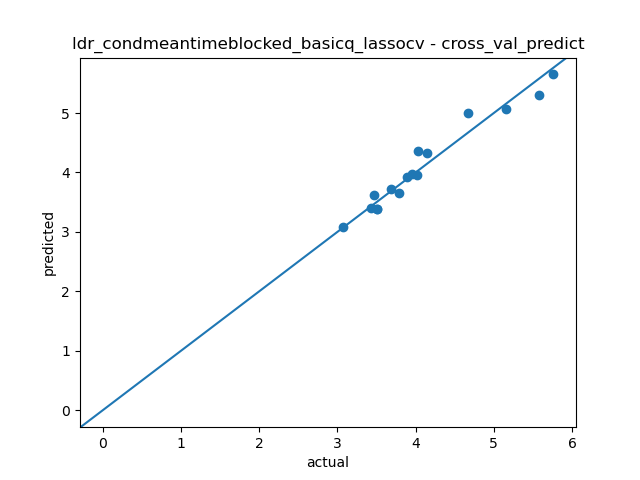

In [47]:
Image('mm_output/exp1/plots/exp1_ldr_ldr_condmeantimeblocked_basicq_lassocv_cv_scatter.png')

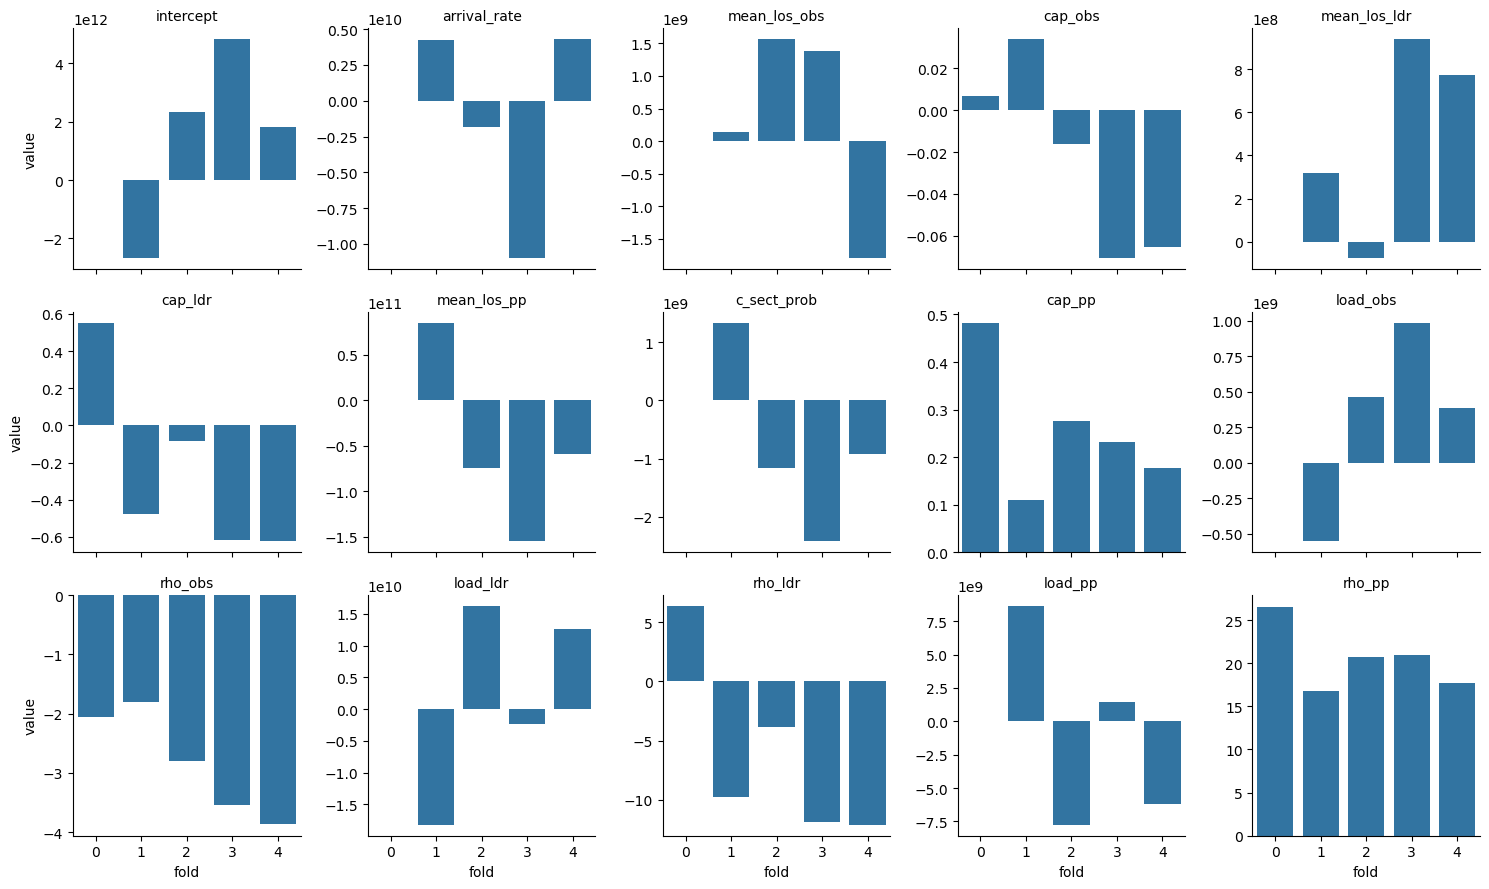

In [49]:
Image('mm_output/exp1/plots/exp1_ldr_ldr_condmeantimeblocked_basicq_lm_cv_coeff.png')

In [39]:
!mm_run_fits_obs exp1 mm_input/exp1/ mm_output/exp1/ mm_output/exp1/plots/

/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.065e-04, tolerance: 4.054e-04
  model = cd_fast.enet_coordinate_descent(
/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e-03, tolerance: 4.054e-04
  model = cd_fast.enet_coordinate_descent(
/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

In [40]:
!mm_run_fits_ldr exp1 mm_input/exp1/ mm_output/exp1/ mm_output/exp1/plots/

/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.947e-03, tolerance: 2.802e-03
  model = cd_fast.enet_coordinate_descent(
/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.947e-03, tolerance: 2.802e-03
  model = cd_fast.enet_coordinate_descent(
/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

In [41]:
!mm_run_fits_pp exp1 mm_input/exp1/ mm_output/exp1/ mm_output/exp1/plots/

/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mark/anaconda3/envs/obflowsim/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
 

## Generate performance curves from fitted models
Now that we have some good performing metamodels, we can use them to do things like generate
predictions for new scenarios using previously fitted models. From these predictions we could generate performance curves to show how some important performance measure changes with respect to one of the input variables.

See our paper for examples of this.



In [1]:
!mm_performance_curves -h

usage: mm_performance_curves [-h]
                             mm_experiment predict_experiment
                             scenario_input_path_filename pkl_path X_data_path
                             output_path

Generate predictions from fitted models

positional arguments:
  mm_experiment         Experiment used to fit metamodels
  predict_experiment    Experiment for which to predict
  scenario_input_path_filename
                        Path to csv file which contains scenario inputs
  pkl_path              Path containing pkl files created from metamodel
                        fitting
  X_data_path           Path to directory in which to write X data for
                        predictions
  output_path           Path to write output csv files

optional arguments:
  -h, --help            show this help message and exit
